# European Drought Observatory - Extract Raw Data


In [2]:
# Magic
# %load_ext autoreload
# %autoreload 2

# Imports

from tqdm import tqdm
import rasterio
import pandas as pd
import glob
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
import chime
import datetime as datetime
from datetime import datetime

from pyprojroot import here

chime.theme("mario")

# Import Functions
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from utilities import *
from gee_data_wrangling import *

# 👉 User Input


In [3]:
# Give list of subfolders
ffolder = here("data/raw/edo/").as_posix() + "/"
ffolder = glob.glob(ffolder + "*")
# Remove those that are not folders
ffolder = [x for x in ffolder if os.path.isdir(x)]
# Remove path from folder
ffolder = sorted([os.path.basename(x) for x in ffolder])

print("Datasets available for extraction:")
for i, f in enumerate(ffolder):
    print(f" {i+1}.\t{f}")

Datasets available for extraction:
 1.	_factsheets
 2.	_world
 3.	cdi
 4.	fapar
 5.	fapar_anom
 6.	grace
 7.	heatw
 8.	maxtmp
 9.	maxtmp_anpm
 10.	mintmp
 11.	smi
 12.	smi_anom
 13.	spi1 - spi3 - spi6


In [5]:
# ❗❗❗ Select dataset that you want to extract by hand ❗❗❗
subfolder = "fapar"
subset_of_coors = False  # Set to true to reduce to only 1000 sites
print(
    f"\n- Extracting {subfolder} data\n- Extracting Subset: {subset_of_coors}\n- Started at {datetime.datetime.now()}"
)


- Extracting fapar data
- Extracting Subset: False
- Started at 2024-01-07 22:06:59.582782


# Load Raster Files


In [6]:
# Get folderpath for selected subfolder
folderpath = here(f"data/raw/edo/{subfolder}/").as_posix() + "/"

# Get list of all files in folder
files = glob.glob(folderpath + "*/*.tif", recursive=True)

# Extract date from filename
dates = [x.split("/")[-1].split("_")[3] for x in files]

# Merge files and dates into dataframe
files_variables = pd.DataFrame({"file": files, "date": dates})

# Format date as datetime
files_variables["date"] = pd.to_datetime(files_variables.date, format="%Y%m%d")
files_variables = files_variables.sort_values("date")

# Attach variable information
files_variables["variable"] = subfolder

print(files_variables.shape)
display(files_variables[:3])

(648, 3)


,file,date,variable
520,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-01-01,fapar
507,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-01-11,fapar
530,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-01-21,fapar


In [7]:
# Attach grouping variable for multiprocessing and create groups
files_variables["group"] = np.arange(len(files_variables)) % 10 + 1
grouped = files_variables.groupby("group")
df_list = [group for name, group in grouped]

display(df_list[0][:3])
display(df_list[-1][:3])

,file,date,variable,group
520,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-01-01,fapar,1
538,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-04-11,fapar,1
505,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-07-21,fapar,1


,file,date,variable,group
517,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-04-01,fapar,10
529,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-07-11,fapar,10
522,/Users/pascal/repos/padasch/ifn_analysis/data/...,2004-10-21,fapar,10


# Example for one raster file


/Users/pascal/repos/padasch/ifn_analysis/data/raw/edo/fapar/fapar_m_euu_20150101_20151221_t/fapar_m_euu_20150121_t.tif
EPSG:4326


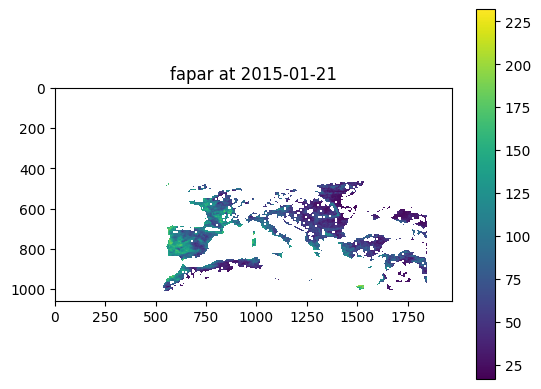

In [8]:
# Pick an arbitrary file to extract raster values from
slice = files_variables.sample(1, random_state=11)
rnd_file = slice["file"].values[0]
rnd_date = slice["date"].astype(str).values[0]

print(rnd_file)

# Load raster file and plot it
with rasterio.open(rnd_file) as src:
    raster = src.read(1)
    raster[raster == -9999] = np.nan

    # Get crs
    file_crs = src.crs.to_string()
    print(file_crs)
    plt.imshow(raster)
    plt.colorbar()
    plt.title(f"{subfolder} at {rnd_date}")

    if subset_of_coors:
        filename = f"edo_qc_files/{subfolder}_raster_from_{rnd_date}_subset.png"
    else:
        filename = f"edo_qc_files/{subfolder}_raster_from_{rnd_date}.png"

    plt.savefig(filename)

# Load and Transform Coordinates


In [9]:
# Load latest coordinates for nfi sites
site_coordinates = get_final_nfi_coordinates("noisy", "csv")

# Get subset of sites if desired
if subset_of_coors:
    site_coordinates = site_coordinates.sample(1000, random_state=42)

# Get a random set of sites to highlight
random_sites = site_coordinates.sample(9, random_state=42)["idp"]

# Turn into geodataframe and set crs to 3035
df_sites_org = site_coordinates.copy()[["idp", "first_year", "x_fr", "y_fr"]]
df_sites_org = gpd.GeoDataFrame(
    df_sites_org,
    geometry=gpd.points_from_xy(df_sites_org.x_fr, df_sites_org.y_fr),
    crs="EPSG:2154",
)

# Turn crs from 2154 to 3035
df_sites_filecrs = df_sites_org.to_crs(file_crs)

# From geodataframe, extract x and y locations
x_filecrs = df_sites_filecrs.geometry.x
y_filecrs = df_sites_filecrs.geometry.y

# Overwrite df_sites again and attach filecrs-based coordinates
df_sites = site_coordinates.copy()[["idp", "first_year"]]
df_sites["x"] = x_filecrs
df_sites["y"] = y_filecrs

# Attach start and end year for each site for easier extraction
df_sites["start_year"] = df_sites.first_year - 5
df_sites["end_year"] = df_sites.first_year + 5

# Print info
print(df_sites.shape)
df_sites.head(3)

Loading noisy coordinates from csv.
(41296, 6)


,idp,first_year,x,y,start_year,end_year
0,500008,2010,6.069031,48.050171,2005,2015
1,500013,2010,1.132647,49.200153,2005,2015
2,500098,2010,4.700861,44.180056,2005,2015


In [10]:
# Create folium map to see if nfi_plots still fall within France
# Get subset to not plot all 40k sites, if not reduced already
if subset_of_coors:
    df_map1 = df_sites_org
    df_map2 = df_sites_filecrs
else:
    df_map1 = df_sites_org.sample(random_state=42, n=1000)
    df_map2 = df_sites_filecrs.sample(random_state=42, n=1000)

# Dataframe to highlight a specific site
df_highlight = df_sites_org.query("idp in @random_sites")

# Make map
m = folium.Map(location=[46.5, 2], zoom_start=6)

# Add original sites to map
folium.GeoJson(
    df_map1,
    name="Original NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="black"),
).add_to(m)

# Add transformed sites to map
folium.GeoJson(
    df_map2,
    name="Transformed NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="red", radius=1),
).add_to(m)

# Add highlighted sites to map
folium.GeoJson(
    df_highlight,
    name="Highlighted NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="blue", radius=5),
).add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Save map
if subset_of_coors:
    m.save(
        f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites_subset.html"
    )
else:
    m.save(f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites.html")

# Show map
m

# Load all years for all files into one dataframe


In [11]:
# Run in parallel
from utilities import parallel_edo_extraction

df_mp = run_mp(
    parallel_edo_extraction,
    df_list,
    progress_bar=True,
    num_cores=10,
    df_sites=df_sites,
    debug=False,
    expected_crs=file_crs,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Unlist results by concatenating them
df_unlisted = pd.concat(df_mp)

# Clean structure a bit
df_unlisted = df_unlisted.sort_values(["idp", "date"]).reset_index(drop=True)
df_unlisted.insert(0, "idp", df_unlisted.pop("idp"))
df_unlisted.insert(1, "date", df_unlisted.pop("date"))

# Set -9999 to NA
df_unlisted = df_unlisted.replace(-9999, np.nan)

# Attach season information
df_unlisted = match_season_to_month(df_unlisted)

# Attach information whether observation is from before or after first_year
# * Important Assumption: Measurement was done on 31st of August (fall-cut-off)
# Code looks ugly but works
df_unlisted["before_first_year"] = df_unlisted["date"] < (
    df_unlisted["first_year"].astype(str) + "-08-31"
).astype("datetime64[ns]")

# Display it
display(df_unlisted)

,idp,date,cdi,first_year,x,y,start_year,end_year,season,before_first_year
0,500002,2012-01-01,0.0,2010,4.126250e+06,2.796779e+06,2005,2015,winter,False
3052908,755105,2012-01-01,0.0,2012,3.328451e+06,2.872217e+06,2007,2017,winter,True
353664,531581,2012-01-01,0.0,2010,3.639925e+06,2.718000e+06,2005,2015,winter,False
7685604,1020038,2012-01-01,0.0,2015,3.714181e+06,2.474067e+06,2010,2020,winter,True
3053124,755107,2012-01-01,0.0,2012,3.800663e+06,2.657033e+06,2007,2017,winter,True
...,...,...,...,...,...,...,...,...,...,...
8766539,1107996,2021-12-21,0.0,2016,3.833406e+06,3.058652e+06,2011,2021,winter,False
8766179,1107992,2021-12-21,2.0,2016,3.863661e+06,2.764124e+06,2011,2021,winter,False
8765819,1107987,2021-12-21,2.0,2016,4.053689e+06,2.915543e+06,2011,2021,winter,False
8769059,1108024,2021-12-21,0.0,2016,3.726702e+06,3.073880e+06,2011,2021,winter,False


# Quality Control of Extraction


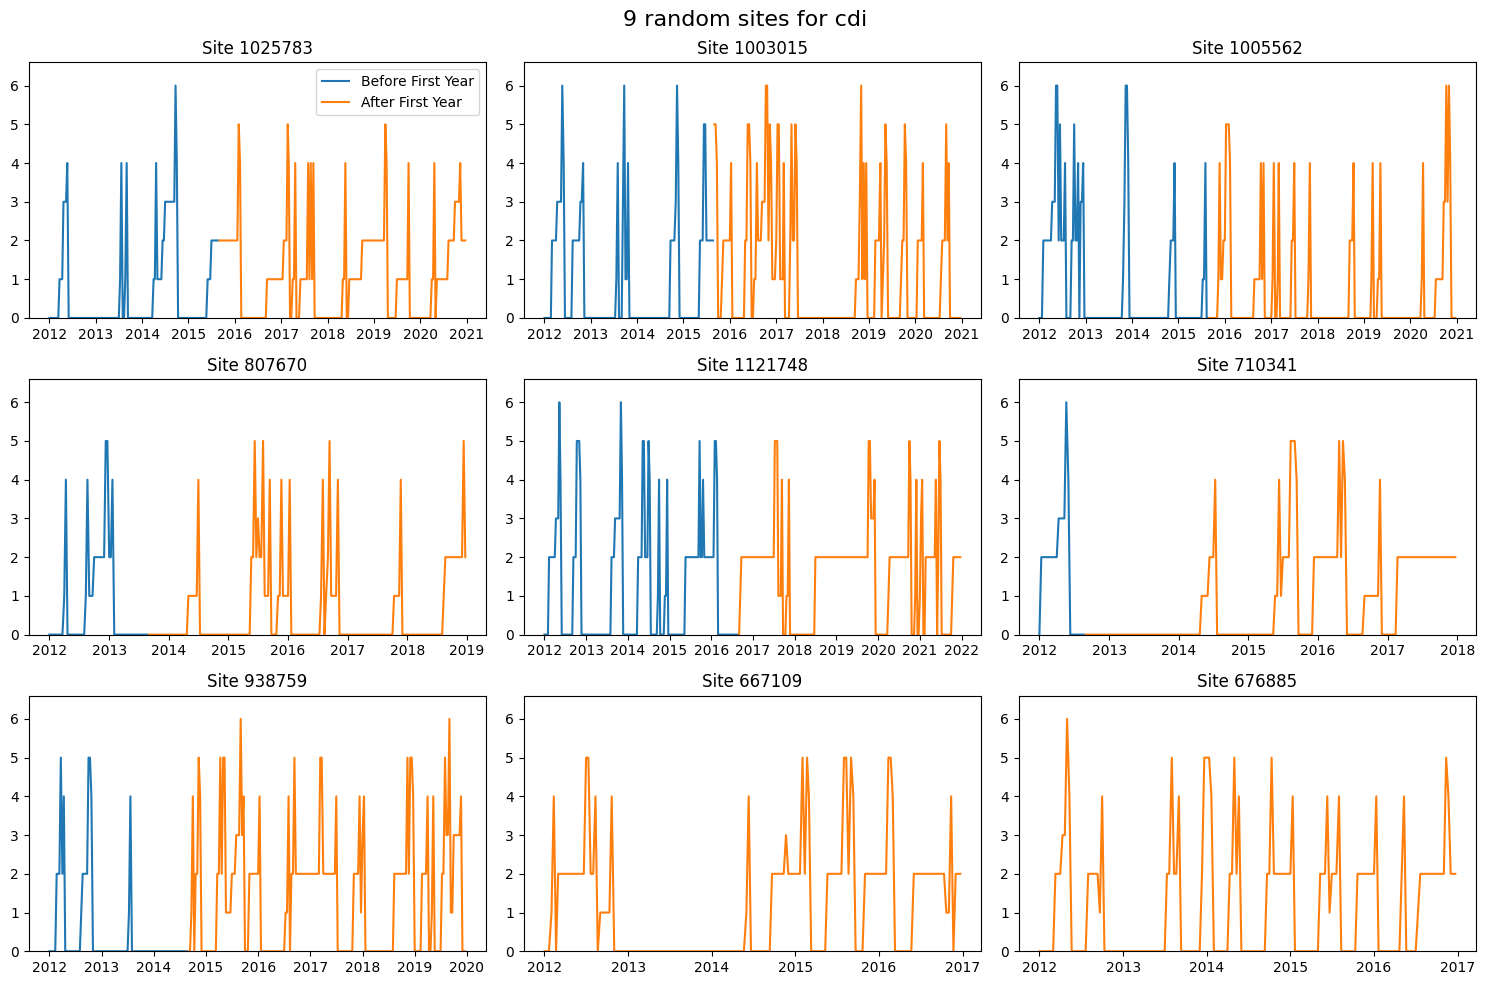

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Add a title to the entire grid
fig.suptitle(f"{len(axes.flatten())} random sites for {subfolder}", fontsize=16)

# Reduce df_unlisted to sites in random_sites
df_red = df_unlisted.query("idp in @random_sites").copy().reset_index(drop=True)

# If heatwave dataset, replace NA by 0 to make plot more readable
if subfolder == "heatw":
    df_red[subfolder] = df_red[subfolder].fillna(0)

# Get minimum and maximum value for y-axis
min_ = df_red[subfolder].min()
max_ = df_red[subfolder].max()

# Iterate over each subplot
for i, ax in enumerate(axes.flatten()):
    # Reduce df_unlisted to sites in random_sites
    random_site = df_red["idp"].unique()[i]

    # Get subset
    subset = df_red[df_red["idp"] == random_site]

    # Plot subset when before_first_year is true
    ax.plot(
        subset[subset["before_first_year"]]["date"],
        subset[subset["before_first_year"]][subfolder],
        label="Before First Year",
    )

    # Plot subset when before_first_year is false
    ax.plot(
        subset[~subset["before_first_year"]]["date"],
        subset[~subset["before_first_year"]][subfolder],
        label="After First Year",
    )

    ax.set_title(f"Site {random_site}")

    # Set y-axis limits
    ax.set_ylim((min_ + min_ * 0.1), (max_ + max_ * 0.1))

# Add legend to the last subplot
axes.flatten()[0].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
if subset_of_coors:
    plotname = f"edo_qc_files/{subfolder}_random_sites_subset.png"
else:
    plotname = f"edo_qc_files/{subfolder}_random_sites.png"
plt.savefig(plotname)

# Show the plot
plt.show()

# Save File


In [ ]:
# Save pre-aggregation dataframe
if subset_of_coors:
    savedfeather = f"edo_qc_files/data_edo_{subfolder}_raw_subset.feather"
else:
    savedfeather = f"edo_qc_files/data_edo_{subfolder}_raw.feather"

df_unlisted.reset_index(drop=True).to_feather(savedfeather)

print(f"✅ Successfully saved dataframe:\t{savedfeather}\t at {datetime.datetime.now()}")
chime.success()

✅ Successfully saved dataframe:	edo_qc_files/data_edo_cdi_raw.feather	 at 2024-01-07 20:17:17.968162
